From: https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

In [2]:
from models_util import build_info_lists

In [3]:
categs = []             # 'translation' or 'english'
texts = []              # actual text content
avg_sent_len = []       # average sentence length
avg_word_len = []       # average word length
stops = []              # percentage of stopwords
f = []

trainDF = pd.DataFrame()

# translated texts
build_info_lists(categs, texts, avg_sent_len, avg_word_len, stops, "translation", f, 100)

# english texts
build_info_lists(categs, texts, avg_sent_len, avg_word_len, stops, "english", f, 83)

# store in dataframe
trainDF['text'] = texts
trainDF['categ'] = categs
trainDF['avg_sent'] = avg_sent_len
trainDF['avg_word'] = avg_word_len
trainDF['stopwords'] = stops

In [4]:
trainDF['label'] = trainDF['categ'].apply(lambda x: 0 if x == "english" else 1)

In [5]:
trainDF

,text,categ,avg_sent,avg_word,stopwords,label
0,I keep a keen eye on the development of Russia...,translation,17.544118,4.403185,0.564124,1
1,A serious scandal has erupted around John Kerr...,translation,21.293333,4.984346,0.482780,1
2,Arms trafficking from the U.S. to Mexico has g...,translation,24.625000,4.840102,0.472081,1
3,Joe Biden has just officially recognized the A...,translation,33.611111,5.084298,0.480992,1
4,Prime Minister Yoshihide Suga will meet U.S. P...,translation,18.240000,4.964912,0.423246,1
...,...,...,...,...,...,...
178,US President Joe Biden is not moving quickly t...,english,17.454545,4.880208,0.466146,0
179,A senior US delegation is visiting the Middle ...,english,22.000000,5.038462,0.411422,0
180,US Secretary of State Antony Blinken delivered...,english,20.945946,4.971613,0.470968,0
181,U.S. President Joe Biden recognized the 1915 e...,english,20.446809,5.002081,0.463059,0


In [6]:
import en_core_web_sm

In [8]:
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    toks = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in toks ]

    # Removing stop words
#     mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

def pos_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    toks = parser(sentence)

    # POS tokens
    POStokens = [ word.pos_.strip() for word in toks ] + [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in toks ]

    # return preprocessed list of tokens
    return POStokens

In [9]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [12]:
bow_vector = CountVectorizer(tokenizer = pos_tokenizer, ngram_range=(1, 1))
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer, ngram_range=(2, 3), max_features=5000)

In [13]:
from sklearn.model_selection import train_test_split

X = trainDF['text'] # the features we want to analyze
ylabels = trainDF['label'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels)

In [15]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x000001FA90C32370>),
                ('vectorizer',
                 TfidfVectorizer(max_features=5000, ngram_range=(2, 3),
                                 tokenizer=<function spacy_tokenizer at 0x000001FA8BDEE0D0>)),
                ('classifier', LogisticRegression())])

In [ ]:
from joblib import dump, load

In [14]:
type(pipe)

sklearn.pipeline.Pipeline

In [16]:
dump(pipe, 'filename.joblib')

['filename.joblib']

In [18]:
predicted = clf.predict(X_test)

In [17]:
clf = load('filename.joblib') 

In [16]:
from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))

Logistic Regression Accuracy: 0.6739130434782609
Logistic Regression Precision: 0.6333333333333333
Logistic Regression Recall: 0.8260869565217391


Text(0.5, 15.0, 'predicted label')

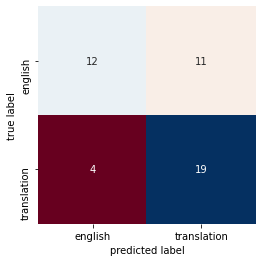

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = metrics.confusion_matrix(y_test, predicted)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False,
xticklabels=['english', 'translation'], yticklabels=['english', 'translation'])
plt.ylabel('true label')
plt.xlabel('predicted label')

In [14]:
df_amazon = pd.read_csv ("amazon_alexa.tsv", sep="\t")
df_amazon.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [15]:
df_amazon.shape

(3150, 5)

In [16]:
df_amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [17]:
df_amazon.feedback.value_counts()

1    2893
0     257
Name: feedback, dtype: int64

In [18]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [19]:
X = df_amazon['verified_reviews'] # the features we want to analyze
ylabels = df_amazon['feedback'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

In [20]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x000001B18F0506A0>),
                ('vectorizer',
                 CountVectorizer(tokenizer=<function spacy_tokenizer at 0x000001B1873663A0>)),
                ('classifier', LogisticRegression())])

In [21]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))

Logistic Regression Accuracy: 0.9513227513227513
Logistic Regression Precision: 0.9570484581497798
Logistic Regression Recall: 0.9920091324200914
